<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/%ED%9A%8C%EC%A0%84%EA%B8%B0%EA%B3%84_%EA%B3%A0%EC%9E%A5%EC%A7%84%EB%8B%A8_%EC%8B%A4%EC%8A%B5_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회전기계 고장진단 실습**

회전기계에서 수집된 진동센서 데이터를 전처리하고, 머신러닝 기법을 이용하여 회전기계의 고장 여부를 판단함

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터와 설명자료를 활용하였고, 교육을 위한 머신러닝 코드를 새롭게 추가하였습니다.

 https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=&page=1&DATASET_SEQ=18

## 0. 회전기계 및 실험 환경

* 산업 현장에서 사용되는 기계 구조물은 대부분 정상 상태로 가동되며, 수집되는 데이터 역시 정상 유형이 90% 이상을 차지하고 고장 데이터는 충분하지 않다.
* Rotor testbed를 이용하여, 여러 고장유형에 대해 특징을 분석하고 정상 및 고장유형을 분류할 수 있는 충분한 양의 고장 데이터를 수집할 수 있다.
* 많은 산업 현장(발전소 등)에서 주로 사용되는 회전 설비의 진동데이터를 수집하고 고장을 분석 및 진단하는 학습 모델을 구축하여, 이후 기술 확장을 통해 발전소나 대규모 공장의 자동화 라인 등에 활용하는 것을 목표로 한다.

![fig.01.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.01.png?raw=true&style=centerme)<br>

(1) Controller Module
- 본 rotor testbed의 Controller에서 수동 모드를 이용하여 Motor 회전속도가 약 1500 RPM인 경우, 진동 데이터를 구축하였다. <br>
<br>

(2) DC Motor
- 본 rotor testbed는 Brush가 없어서 기계적인 접촉이 없는 Brushless DC (BLDC) Motor를 사용한다.
- Brushless DC Motor는 소음이 비교적 적으며, 출력을 세밀하게 조절할 수 있다는 장점이 있다.<br>
![BLDC_motor.jpg](https://raw.githubusercontent.com/jjyjung/ai_mfg/main/img/BLDC_motor.jpg)<br>
<br>

(3) Disk
- 본 rotor testbed는 총 2개의 aluminum disk가 있다.
- 각 disk에는 회전 불균형을 테스트할 수 있는 bolt 체결 홀이 있다.
- 축 중심으로부터 bolt 체결 홀까지의 거리는 약 60mm이며, blot 체결 홀은 모두 36개이다.<br>
![fig.02.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.02.png?raw=true)<br>
<br>

(4) Rotor Spec.
- 본 rotor testbed의 사양은 다음과 같다.

|    구분    |                 사양                 |
|:----------:|:------------------------------------:|
| Size       | 673 mm (W) x 280 mm (D) x 281 mm (H) |
| Weight     |                 25kg                 |
| Material   |               Aluminum               |
| Bearing    |             6202ZZ x 2EA             |
| Motor      |  DC 12V x 0.25 HP (0.2W), 0-3000 RPM  |
| Main power |                AC 220V               |

(5) 실험 환경
- 회전 속도는 약 1500 RPM (Revolutions Per Minute)을 사용하였으며, 이 경우 기계의 최대 주파수는 25 Hz (= 1500 RPM / 60 sec)가 된다.
- 나이퀴스트 (Nyquist) 이론에 따르면 기계의 최대 주파수의 2배 이상으로 sampling rate을 해야하지만, 실제 산업에서는 안정적인 신호 분석을 위해서 통상 최대 주파수의 5-10배 정도의 sampling rate를 수행한다.
- 본 실험 데이터는 이보다 충분하게 최대 주파수의 40배 정도인 1 kHz의 진동 데이터(가속도)로 수집하였다.

| Rotor testbed |                   |
|:-------------:|:-----------------:|
| RPM           |     about 1500    |
| Sampling rate | 1 kHz (0.001 sec) |

## 1. 고장실험 데이터
### 1-1. 고장 데이터 수집

- 총 4개의 센서를 사용하고 sensor1~sensor4로 명명한다.<br>
- 센서 데이터 취득 위치는 다음과 같다.<br>
<br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor1.png?raw=true"><br>[센서 설치 위치 (사진)]</center> <br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor2.png?raw=true"><br>[센서 부착 위치 (빨간색)]</center> <br>

<!--center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor3.png?raw=true"><br>[group 2]</center> <br>
<br-->

- data는 데이터 취득 시간, 정상 유형(normal)과 고장유형 1, 2, 3 (type1, type2, type3) 경우의 센서값으로 구성된다. <br>
- 고장유형 1, 2, 3은 다음의 사진과 표로 확인할 수 있다.<br>

![fault_type.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fault_type.png?raw=true)<br>

| 구분   | 특징                                                |
|--------|-----------------------------------------------------|
| Type 1 | Disk 2에 회전 불균형 (270도 위치에 볼트, 너트 부착) |
| Type 2 | Support 4에 지지 불균형                             |
| Type 3 | Type 1 + Type 2                                     |


### 1-2. 고장 데이터 업로드

 * **[중요] Sensor 파일 4개 업로드**
  * 파일 링크: https://drive.google.com/drive/folders/1vSmW1FFWQYeP6NWeX70sVn1QBNnCax7E?usp=drive_link
  * **rotor.zip** 파일의 압축을 풀어서, csv 파일 4개를 Colab 왼쪽의 폴더에 업로드 하세요. (drag & drop 하면 됩니다.)
  * 파일 업로드가 끝나면 아래 코드를 실행시켜 보시오.

In [ ]:
# 필요한 패키지(라이브러리) 로딩
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# 4개 센서 데이터를 읽어들이기 위하여 아래 코드를 실행합니다.
sensor1 = pd.read_csv('/content/g1_sensor1.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv('/content/g1_sensor2.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv('/content/g1_sensor3.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv('/content/g1_sensor4.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])

### 1-3. 데이터 확인
* 불러온 데이터프레임의 변수 이름(예. sensor1, sensor2 등)을 입력하면 해당 내용을 확인할 수 있습니다.
* **[TEST] 아래 코드에서 sensor 번호를 바꾸어가면서, sensor 2, sensor 3, sensor 4의 내용도 확인해보시오.**

In [ ]:
print('sensor 1의 데이터 크기 :', sensor1.shape)
print('sensor 2의 데이터 크기 :', sensor2.shape)
print('sensor 3의 데이터 크기 :', sensor3.shape)
print('sensor 4의 데이터 크기 :', sensor4.shape)

sensor1

sensor 1의 데이터 크기 : (190218, 5)
sensor 2의 데이터 크기 : (184211, 5)
sensor 3의 데이터 크기 : (196079, 5)
sensor 4의 데이터 크기 : (183969, 5)


,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


* 140초 동안 수집된 데이터가 5개의 컬럼에 저장되어 있다.
* 그러나 데이터 크기를 확인해보면 센서들의 미세한 sampling rate 차이로 데이터 개수가 조금씩 다른 것을 알 수 있다.
* 따라서 동일한 time interval의 데이터를 취득하기 위해 데이터를 0.001 sec 간격으로 선형보간을 수행한다.

### 1-4. 데이터 선형보간

* 계측한 센서들의 계측 시간 간격이 일정하지 않은 경우, 데이터 간 정확한 비교가 어려우므로 계측 시간의 동일화를 위해 전처리(선형 보간)가 필요하다. 선형보간의 방법은 아래 그림과 같다.<br>

![interpolation.png](https://github.com/jjyjung/ai_mfg/blob/main/img/interpolation.png?raw=true)<br>
<br>
* 각 센서의 데이터를 0.001 sec 간격으로 선형보간 한다 (총 140초). <br>
 - interpolate.interp1d() : [선형보간 함수](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)를 이용하였다.

In [ ]:
from scipy import interpolate

x_new = np.arange(0, 140, 0.001)  # 0~140 구간을 0.001 간격으로 나눔

y_new1 = []; y_new2 = []; y_new3 = []; y_new4 = []
for item in ['normal', 'type1', 'type2', 'type3']:
    f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear'); y_new1.append(f_linear1(x_new))
    f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear'); y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear'); y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear'); y_new4.append(f_linear4(x_new))

sensor1 = pd.DataFrame(np.array(y_new1).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor2 = pd.DataFrame(np.array(y_new2).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor3 = pd.DataFrame(np.array(y_new3).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor4 = pd.DataFrame(np.array(y_new4).T, columns = ['normal', 'type1', 'type2', 'type3'])

normal_ = pd.concat([sensor1['normal'],sensor2['normal'],sensor3['normal'],sensor4['normal']],axis=1)
type1_  = pd.concat([sensor1['type1'], sensor2['type1'], sensor3['type1'], sensor4['type1']], axis=1)
type2_  = pd.concat([sensor1['type2'], sensor2['type2'], sensor3['type2'], sensor4['type2']], axis=1)
type3_  = pd.concat([sensor1['type3'], sensor2['type3'], sensor3['type3'], sensor4['type3']], axis=1)

normal_.columns = ['s1', 's2', 's3', 's4']
type1_.columns = ['s1', 's2', 's3', 's4']
type2_.columns  = ['s1', 's2', 's3', 's4']
type3_.columns = ['s1', 's2', 's3', 's4']

print('normal의 데이터 크기 :', normal_.shape)
print('type1의 데이터 크기 :', type1_.shape)
print('type2의 데이터 크기 :', type2_.shape)
print('type3의 데이터 크기 :', type3_.shape)

normal_

normal의 데이터 크기 : (140000, 4)
type1의 데이터 크기 : (140000, 4)
type2의 데이터 크기 : (140000, 4)
type3의 데이터 크기 : (140000, 4)


,s1,s2,s3,s4
0,-0.853307,0.048823,-0.437626,-1.116226
1,-0.524588,-0.029477,-0.149817,-0.659694
2,-0.003708,-0.004751,0.280889,-0.857345
3,-0.297674,0.009673,-0.303281,-0.685318
4,-0.091203,0.096215,-0.320263,-0.303108
...,...,...,...,...
139995,-1.057411,0.587429,0.275044,0.289837
139996,-0.513635,-0.137874,-0.045973,0.131462
139997,-1.085213,0.002242,-0.164593,-0.087380
139998,-0.677177,-0.308897,0.288252,1.319862


* 정상 유형(normal)과 고장유형 1, 2, 3 (type1, type2, type3)별로 센서 데이터를 취합한다.

* **[TEST] 아래 코드에서 Class 이름을 바꾸어가면서, type1_, type2_, type3_의 내용도 확인해보시오.**

### 1-5. 데이터 시각화
* 특정 시간에서의 시계열 샘플을 그래프로 그려봅시다.
* 아래는 Sensor 1에서 수집된 normal, type1, type2, type3의 상태 그래프를 보여주고 있습니다.
* **[TEST] Sensor 2, Sensor 3, Sensor 4의 normal과 type1, type2, type3 상태 그래프도 그려보고 서로 비교해 보시오.** ('s1'을 's2'로 바꾸면 됨)
* **[질문] 네 가지 센서 중에서 어떤 센서가 가장 고장 진단에 가장 유용할 것으로 예상되는가?**

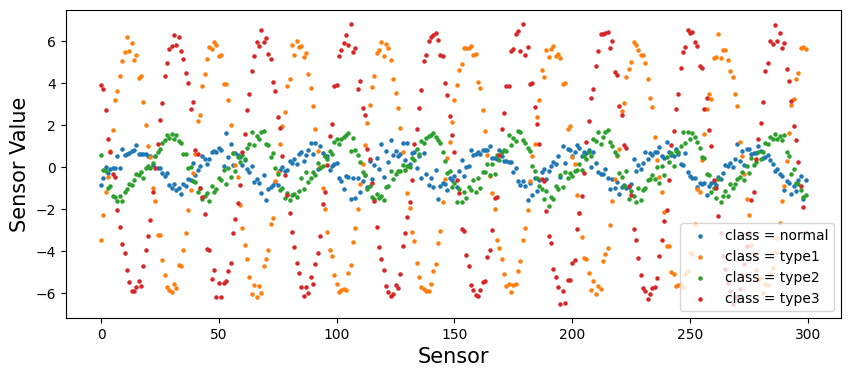

In [ ]:
# python 버전 : 3.7.3 (버전에 따라, jupyter notebook에서 아래 코드가 실행되지 않을 수 있습니다)
# 실행이 되지 않는 경우, 아래 코드는 주석처리하고 넘어가도 고장진단 학습에는 영향을 주지 않습니다. (데이터 확인용)

plt.figure(figsize = (10, 4))

ss = 's1'
plt.scatter(range(0,300), normal_[ss][:300], label="class = normal", marker='o', s=5)
plt.scatter(range(0,300), type1_[ss][:300], label="class = type1", marker='o', s=5)
plt.scatter(range(0,300), type2_[ss][:300], label="class = type2", marker='o', s=5)
plt.scatter(range(0,300), type3_[ss][:300], label="class = type3", marker='o', s=5)

plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=15)
plt.ylabel("Sensor Value", fontsize=15)
plt.show()
plt.close()

## 2. 데이터 전처리

### 2-1. 데이터 필터링 (Filtering)

* 센서 데이터는 계측 중에 많은 노이즈(Noise)가 포함되어 있습니다. 주위 데이터와 평균을 취하여 데이터 노이즈를 쉽게 제거할 수 있는데, 본 예제에서는 이동평균필터(Moving Average filter)를 사용합니다.

* 이동평균필터 (Moving Average filter)는 python에서 [np.convolve()](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) 함수로 구현됩니다 (MATLAB의 filter 함수와 동일). <br>
    * np.convolve() : 1차원 신호를 입력으로 받아, 최근 M개의 측정값들의 평균을 구합니다.
    * 일반적으로 신호 데이터의 변동이 빠른 경우에는 M 값을 작게 하고, 신호 데이터의 변동이 느린 경우에는 M 값을 크게 합니다. <br>
    * 자세한 이론은 [자료](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)를 참고하세요.

In [ ]:
M = 15

normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid') / M; normal_s1 = normal_s1.reshape(len(normal_s1),1)
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid') / M; normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid') / M; normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid') / M; normal_s4 = normal_s4.reshape(len(normal_s4),1)

type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid') / M; type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid') / M; type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid') / M; type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid') / M; type1_s4 = type1_s4.reshape(len(type1_s4),1)

type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid') / M; type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid') / M; type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid') / M; type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid') / M; type2_s4 = type2_s4.reshape(len(type2_s4),1)

type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid') / M; type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid') / M; type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid') / M; type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid') / M; type3_s4 = type3_s4.reshape(len(type3_s4),1)

normal_temp = np.concatenate((normal_s1,normal_s2,normal_s3,normal_s4), axis = 1)
type1_temp = np.concatenate((type1_s1,type1_s2,type1_s3,type1_s4), axis = 1)
type2_temp = np.concatenate((type2_s1,type2_s2,type2_s3,type2_s4), axis = 1)
type3_temp = np.concatenate((type3_s1,type3_s2,type3_s3,type3_s4), axis = 1)

normal_temp.shape

(139986, 4)

### 2-2. 데이터 정규화

* 이동평균을 적용하였기 때문에 데이터의 크기가 M-1 만큼 축소되었습니다.
* 데이터 (139986,4)의 센서 값들이 크기가 서로 다르면 SVM, 신경망 등 모형의 학습에 그대로 이용하기에 적절하지 않습니다. <br>
* 일반적으로 입력값들을 정규화(Normalization)하는데, 본 예제에서는 Min-max normalization 활용하여 진행합니다. <br>
* Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling 합니다.

 1) 대상 데이터들의 최대값(max)과 최소값(min)을 구한다. <br>
 2) 정규화할 데이터 값(x)에 최대값(Xmax), 최소값(Xmin)을 적용하여 다음의 식과 같이 변환합니다.<br>
<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/minmax.png?raw=true"></center>

 3) 위의 식은 sklearn.preprocessing의 MinMaxScaler에 구현되어 있습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(normal_temp)
normal = scaler.transform(normal_temp)
type1  = scaler.transform(type1_temp)
type2  = scaler.transform(type2_temp)
type3  = scaler.transform(type3_temp)

normal = normal[30000:130000][:]
type1  = type1[30000:130000][:]
type2  = type2[30000:130000][:]
type3  = type3[30000:130000][:]

print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[0.29729147 0.77473942 0.48703584 0.16238024]
 [0.23341712 0.71613113 0.38166177 0.14740713]
 [0.18567516 0.69000953 0.40450928 0.14239743]
 ...
 [0.43052446 0.64542681 0.71956239 0.37861583]
 [0.35189898 0.66088486 0.71873981 0.30739699]
 [0.3032716  0.72213838 0.62794618 0.25869938]]
------------------------------------------------
normal data size =  (100000, 4)


* rotor testbed 가동 후 정상 가동 전까지 일부 시간(여기에서는 30초)의 데이터를 탈락시키고(warm-up 시간), 이후의 안정적인 상태의 데이터(steady state)를 분석에 사용합니다.
* 본 예제에서는 편의상 140초 중 30초 이후 100초 동안의 데이터를 (100000, 4)로 추출합니다.(sampling rate이 1 kHz이므로 100초 x 1000개)

### 2-3. 데이터 분할

* 공정한 평가를 위하여 Normal, type1, type2, type3 데이터를 학습용(training data)과 테스트용(test data)으로 나누어야 합니다.
* 본 예제에서는 학습용 : 테스트용 데이터를 7:3 으로 분할합니다.

In [ ]:
# 데이터 분할
normal_train = normal[:][:70000]; normal_test = normal[:][70000:]
type1_train  = type1[:][:70000];  type1_test  = type1[:][70000:]
type2_train  = type2[:][:70000];  type2_test  = type2[:][70000:]
type3_train  = type3[:][:70000];  type3_test  = type3[:][70000:]

### 2-4. 통계적 지표(SI) 추출

* SVM, Random Forest 등 머신러닝 모형의 학습에 100000개 시계열 데이터를 직접 입력하면 학습이 잘 되지 않기 때문에, 시계열 데이터의 통계적 지표(SI)를 추출하여 입력으로 사용합니다.
* 본 예제에서는 0.5초를 하나의 구간으로 보고, 각 구간에서 평균, 표준편차, 첨도, 왜도 등 10가지 통계적 지표를 추출하여 사용합니다.


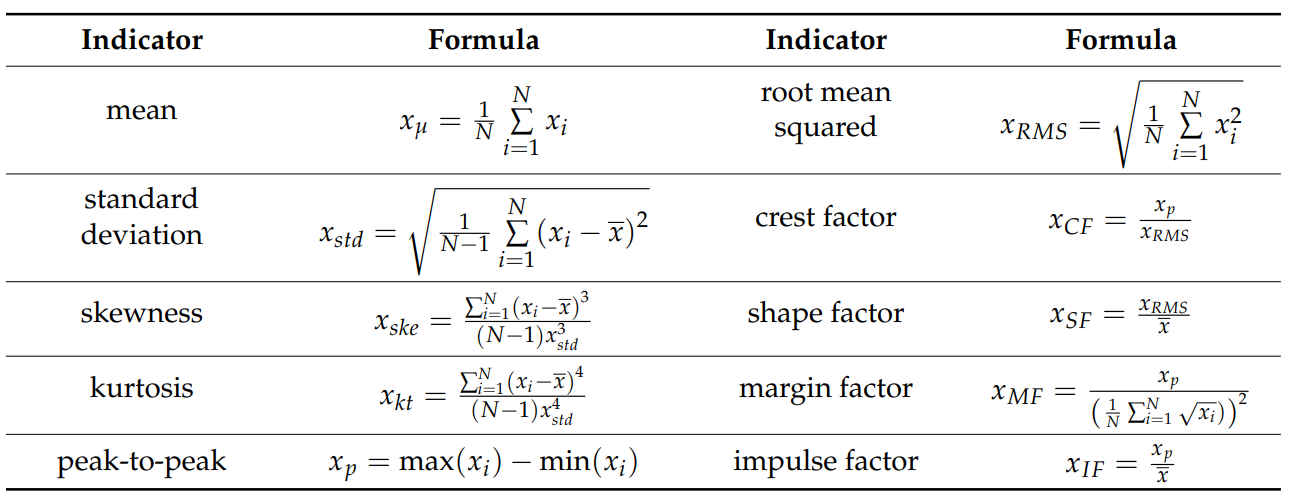

* 통계적 지표(SI)를 추출하는 함수 정의
* 0.5초씩 구간을 나누는 함수 정의
* 두 가지 함수를 실행시켜, 네 가지 class의 데이터를 0.5초로 분할한 후, SI 지표를 추출함

In [ ]:
# 통계적 지표(SI) 함수 정의
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)

def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)

def make_df(x, sensor_num):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)

    # df = pd.DataFrame({'mean_'+sensor_num:mean_value})
    df = pd.DataFrame({'mean_'+sensor_num:mean_value, 'std_'+sensor_num:std_value})
    # df = pd.DataFrame({'mean_'+sensor_num:mean_value, 'std_'+sensor_num:std_value, 'skewness_'+sensor_num:skewness_value,
    #                    'kurtosis_'+sensor_num:kurtosis_value, 'p2p_'+sensor_num:p2p_value, 'rms_'+sensor_num:rms_value,
    #                    'crest_'+sensor_num:crestFactor_value, 'shape_'+sensor_num:shapeFactor_value,
    #                    'margin_'+sensor_num:marginFactor_value, 'impulse_'+sensor_num:impulseFactor_value})

    return(df)

# 0.5초 구간별로 분할하여 SI를 측정하는 함수 정의
def generate_data(data):
  data = pd.DataFrame(data)
  df = pd.DataFrame()
  i = 0
  window_len = 500
  while data.shape[0] >= window_len:
    input = data.iloc[window_len*i:window_len*(i+1),:]
    input_arr = np.array(input).reshape((1,-1))
    df = pd.concat([df, pd.DataFrame(input_arr)], axis=0)
    # print(df)
    data = data.iloc[window_len*(i+1):,:]
    # i += 1

  df = df.reset_index(drop=True)
  return df #.drop(index=df.index[-1])


def extract_SI(data):
  s1_tmp = generate_data(data[:,0])
  s2_tmp = generate_data(data[:,1])
  s3_tmp = generate_data(data[:,2])
  s4_tmp = generate_data(data[:,3])

  s1_ext = make_df(s1_tmp, 's1')
  s2_ext = make_df(s2_tmp, 's2')
  s3_ext = make_df(s3_tmp, 's3')
  s4_ext = make_df(s4_tmp, 's4')

  df = pd.concat([s1_ext, s2_ext, s3_ext, s4_ext], axis=1)
  # df = pd.concat([s4_ext], axis=1)
  return df


# 0.5초 분할 및 SI 측정하는 코드 실행
normal_train_ext = extract_SI(normal_train)
type1_train_ext = extract_SI(type1_train)
type2_train_ext = extract_SI(type2_train)
type3_train_ext = extract_SI(type3_train)

normal_test_ext = extract_SI(normal_test)
type1_test_ext = extract_SI(type1_test)
type2_test_ext = extract_SI(type2_test)
type3_test_ext = extract_SI(type3_test)


print('normal_train_ext의 데이터 크기 :', normal_train_ext.shape)
print('normal_test_ext의 데이터 크기 :', normal_test_ext.shape)

# print(normal_train_ext)


# Normal, Type1, Type2, Type3에 대하여 0, 1, 2, 3으로 라벨링 부여
normal_train_ext_labeled = np.append(normal_train_ext, np.repeat(0, normal_train_ext.shape[0]).reshape(normal_train_ext.shape[0], 1), axis=1)
type1_train_ext_labeled = np.append(type1_train_ext, np.repeat(1, type1_train_ext.shape[0]).reshape(type1_train_ext.shape[0], 1), axis=1)
type2_train_ext_labeled = np.append(type2_train_ext, np.repeat(2, type2_train_ext.shape[0]).reshape(type2_train_ext.shape[0], 1), axis=1)
type3_train_ext_labeled = np.append(type3_train_ext, np.repeat(3, type3_train_ext.shape[0]).reshape(type3_train_ext.shape[0], 1), axis=1)

normal_test_ext_labeled = np.append(normal_test_ext, np.repeat(0, normal_test_ext.shape[0]).reshape(normal_test_ext.shape[0], 1), axis=1)
type1_test_ext_labeled = np.append(type1_test_ext, np.repeat(1, type1_test_ext.shape[0]).reshape(type1_test_ext.shape[0], 1), axis=1)
type2_test_ext_labeled = np.append(type2_test_ext, np.repeat(2, type2_test_ext.shape[0]).reshape(type2_test_ext.shape[0], 1), axis=1)
type3_test_ext_labeled = np.append(type3_test_ext, np.repeat(3, type3_test_ext.shape[0]).reshape(type3_test_ext.shape[0], 1), axis=1)

# print(type2_train_ext_labeled)
# print('------------------------------------------------')
# print(normal_train_ext_labeled.shape)
# print(type1_train_ext_labeled.shape)
# print(type2_train_ext_labeled.shape)
# print(type3_train_ext_labeled.shape)


combined_trn = np.concatenate((normal_train_ext_labeled, type1_train_ext_labeled, type2_train_ext_labeled, type3_train_ext_labeled))
combined_test = np.concatenate((normal_test_ext_labeled, type1_test_ext_labeled, type2_test_ext_labeled, type3_test_ext_labeled))

np.random.shuffle(combined_trn)
np.random.shuffle(combined_test)


print(combined_trn)
print('------------------------------------------------')
print(combined_trn.shape)
print(combined_test.shape)

normal_train_ext의 데이터 크기 : (140, 8)
normal_test_ext의 데이터 크기 : (60, 8)
[[0.55346892 0.30308076 0.53642403 ... 0.42103128 0.22204128 0.        ]
 [0.5457985  0.293168   0.54608175 ... 0.42656404 0.25718286 2.        ]
 [0.5418703  0.28977559 0.54300906 ... 0.43164768 0.27513782 2.        ]
 ...
 [0.54572774 0.86284984 0.55812699 ... 0.42564476 0.36400962 3.        ]
 [0.55837426 0.77211271 0.55881051 ... 0.42097032 0.17579519 1.        ]
 [0.54730632 0.30424415 0.54045518 ... 0.42960041 0.28601478 2.        ]]
------------------------------------------------
(560, 9)
(240, 9)


* 혼합된 학습데이터를 만들기 이전에 Normal, Type1, Type2, Type3 데이터의 클래스를 각각 0, 1, 2, 3으로 라벨링 부여합니다.

* 골고루 학습하고 테스트하기 위하여, 학습 및 평가 데이터들에 Shuffling을 수행합니다.

## 3. 모델 설명



###3-1. 의사결정나무 (Decision Tree)
* 의사결정나무(DT: Decision Tree)는 변수의 값에 따라 분할하는 규칙을 순차적으로 적용하여 데이터를 분류하는 기법

 ![dt_table.png](https://av-eks-blogoptimized.s3.amazonaws.com/905753.png)
 ![dt_table.png](https://av-eks-blogoptimized.s3.amazonaws.com/542834.png)

###3-2. 서포트 벡터 머신 (SVM)
* 서포트 벡터 머신(SVM: Support vector machine)은 벡터 공간에서 두 클래스를 구분하는 가장 여유(margin) 있는 결정 경계(decision boundary)를 찾는 분류기

 ![svm.jpg](https://ars.els-cdn.com/content/image/3-s2.0-B978032385214200001X-f06-02-9780323852142.jpg)<br>

### 3-3. 랜덤 포레스트 (Random Forest)
* 랜덤 포레스트(RF: Random Forest)는 훈련 데이터에서 복원 추출하여 생성한 다수의 데이터셋으로부터 다수의 의사결정나무(Decision Tree)를 학습시킨 후, 다수의 의사결정나무의 예측값의 평균으로 최종 예측하는 분류 또는 회귀 기법

 ![rf.svg](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg)<br>

## 4. 모델 학습

### 4-1. 의사결정나무 (Decision Tree)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................

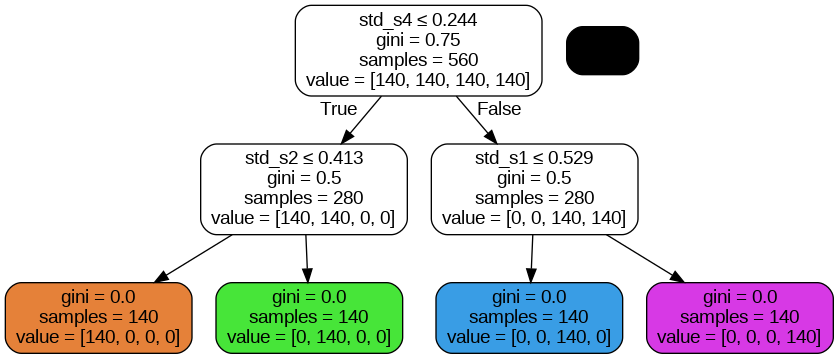

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, 5, 7]}

tuned_dt = GridSearchCV(dt_model, param_grid=param_dist, verbose=2, refit=True)
tuned_dt.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_dt.best_params_)


from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

x_list = list(normal_train_ext.columns)
dot_data = export_graphviz(tuned_dt.best_estimator_, out_file=None, feature_names=x_list,
                          filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

* **Gini index**

 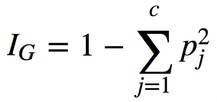

### 4-2. 서포트 벡터 머신 (SVM)

In [ ]:
from sklearn import svm
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

# SVM
SVM_model = svm.SVC()

param_dist = {"C" : [10, 50, 100], "kernel": ['linear', 'rbf', 'poly']}

tuned_svm = GridSearchCV(SVM_model, param_grid=param_dist, verbose=1, refit=True)
tuned_svm.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_svm.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 10, 'kernel': 'linear'}


### 4-3. 랜덤 포레스트 (Random Forest)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
RF_model = RandomForestClassifier()

param_dist = {"n_estimators": [10, 50],
              "max_depth": [3, 5, 10]}

tuned_rf = GridSearchCV(RF_model, param_grid=param_dist, verbose=1, refit=True)
tuned_rf.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_rf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 5, 'n_estimators': 10}


## 5. 모델 평가

* 학습된 ML 모델의 성능 평가하는 함수

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_pred):
  accuracy = accuracy_score(combined_test[:,-1], y_pred)
  f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
  print('Accuracy: ', "%.2f" % (accuracy*100))
  print('F1: ', "%.2f" % (f1*100))

  # Confusion Matrix 생성
  Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

  cm_df = pd.DataFrame(Confusion_Matrix,
                      index = ['normal','type1','type2','type3'],
                      columns = ['normal','type1','type2','type3'])

  #Plotting the confusion matrix
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal')
  plt.xlabel('Predicted')
  plt.show()

#### 5-1. 의사결정나무 (Decision Tree)

Accuracy:  100.00
F1:  100.00


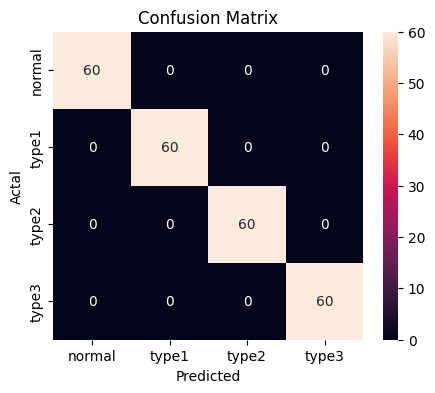

In [ ]:
y_pred = tuned_dt.predict(combined_test[:,:-1])
show_confusion_matrix(y_pred)

#### 5-3. 서포트 벡터 머신 (SVM)

Accuracy:  100.00
F1:  100.00


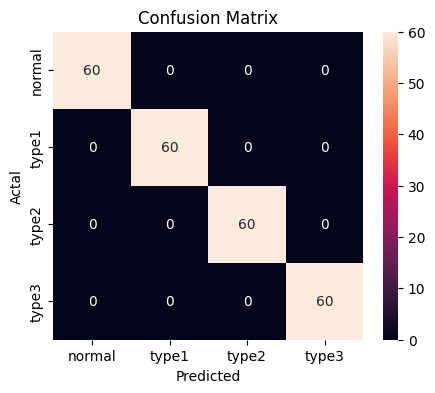

In [ ]:
y_pred = tuned_svm.predict(combined_test[:,:-1])
show_confusion_matrix(y_pred)

#### 5-3. 랜덤 포레스트 (Random Forest)

Accuracy:  100.00
F1:  100.00


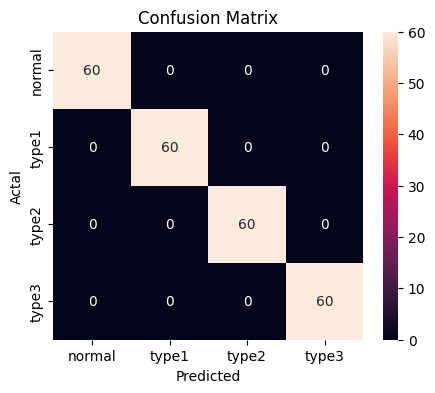

In [ ]:
y_pred = tuned_rf.predict(combined_test[:,:-1])
show_confusion_matrix(y_pred)